### aim: Recreate Terhaar's fig x3.4.2 with various model simulations 

goal is to compare several different runs for accumulation of anthropogenic carbon and other relevant run metrics.

### date: 


<img src="./Terhaarx3.4.2.png"  width="600" height="300">

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [4]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

### 1) Calculate C-anth from 2022 milestone GCB model, from GCB methodology:

    - GCB year 2002 for simulations B and C (C-B) visualise

In [5]:
## get the relevant years
yr = 2002


GCB_DW_C_f = f'/gpfs/data/greenocean/software/runs/TOM12_DW_GC01/ORCA2_1m_{yr}0101_*_ptrc_T.nc'
GCB_DW_B_f = f'/gpfs/data/greenocean/software/runs/TOM12_DW_GB01/ORCA2_1m_{yr}0101_*_ptrc_T.nc'

GCB_DW_C = xr.open_dataset(glob.glob(GCB_DW_C_f)[0])
GCB_DW_B = xr.open_dataset(glob.glob(GCB_DW_B_f)[0])

DG1_TJ_C_f = f'/gpfs/data/greenocean/software/runs/TOM12_TJ_DGC1/ORCA2_1m_{yr}0101_*_ptrc_T.nc'
DG1_TJ_B_f = f'/gpfs/data/greenocean/software/runs/TOM12_TJ_DGB1/ORCA2_1m_{yr}0101_*_ptrc_T.nc'

GCB_TJ_C = xr.open_dataset(glob.glob(DG1_TJ_C_f)[0])
GCB_TJ_B = xr.open_dataset(glob.glob(DG1_TJ_B_f)[0])

DG1_TJ_C_f = f'/gpfs/data/greenocean/software/runs/TOM12_TJ_GEC0/ORCA2_1m_{yr}0101_*_ptrc_T.nc'
DG1_TJ_B_f = f'/gpfs/data/greenocean/software/runs/TOM12_TJ_GEB0/ORCA2_1m_{yr}0101_*_ptrc_T.nc'

GCBn_TJ_C = xr.open_dataset(glob.glob(DG1_TJ_C_f)[0])
GCBn_TJ_B = xr.open_dataset(glob.glob(DG1_TJ_B_f)[0])

In [6]:
#tj broadcast a depth array of e3t_0 to get its dimensions to match the model output we are trying to calculate for. 
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
e3t_0 = tmesh.e3t_0
e3t_0_rn = e3t_0.rename({'t': 'time_counter','z': 'deptht'})
e3t_0_rn_b = np.zeros([12,31,149,182])

for i in range(0,12):
    e3t_0_rn_b[i,:,:,:] = e3t_0_rn.values
    
# savenam = 'test2.nc'
data_vars = {'e3t_0':(['time_counter', 'deptht', 'y', 'x'], e3t_0_rn_b,
{'units': 'm',
'long_name':'meters, t grid'}),
}
# define coordinates
coords = {'time_counter': (['time_counter'], GCB_DW_C.time_counter),
'y': (['y'], tmesh.y.values),
'x': (['x'], tmesh.x.values),
'deptht': (['deptht'], GCB_DW_C.deptht.values)}
# define global attributes
attrs = {'made in':'SOZONE/GRO2_FORCING_EXPERIMENT/anthCarbonAccumulation_figx3.4.2.ipynb',
'desc': 'a broadcasted e3t_0 into 12 months, for multiplication'
}
ds = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)


Text(0.5, 1.0, 'Anth DIC accumulation to year 2002, \n calculated as DW_GCB_simC - DW_GCB_simB, year 2002 \n ~problematic~ Pacific accumulation visible')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


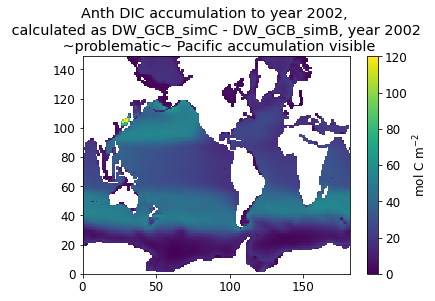

In [7]:
DIC_DW_C_molm2 = GCB_DW_C.DIC.load() * ds.e3t_0.load() * 1000 
DIC_DW_B_molm2 = GCB_DW_B.DIC.load() * ds.e3t_0.load() * 1000 
#multiplying by 1000 goes from mol/L > mol/m3, multiplying by ds.e3t_0 should give you  mol/m2

test = False
if test:
    #this checks that it did the thing and all the dimensions make sense
    print(GCB_DW_C.DIC[0,0:4,50,100].values)
    print(ds.e3t_0[0,0:4,50,100].values)
    print(GCB_DW_C.DIC[0,0:4,50,100].values * ds.e3t_0[0,0:4,50,100].values)
    print(DIC_DW_C_molm2[0,0:4,50,100].values)
    
    
anth_DIC_molm2 = DIC_DW_C_molm2-DIC_DW_B_molm2
anth_DIC_molm2 = anth_DIC_molm2[:,0:27,:,:] #to 3000 m depth approximately, last cell has depth 3257
anth_DIC_molm2_2d = np.nanmean(np.nansum(anth_DIC_molm2, axis = 1), axis = 0) #yearly mean, summed across depths

anth_DIC_molm2_2d[anth_DIC_molm2_2d == 0] = np.nan
w = plt.pcolormesh(anth_DIC_molm2_2d, vmin = 0, vmax = 120)
plt.colorbar(w, label = 'mol C m$^{-2}$', )
plt.title('Anth DIC accumulation to year 2002, \n calculated as DW_GCB_simC - DW_GCB_simB, year 2002 \n ~problematic~ Pacific accumulation visible')

Text(0.5, 1.0, 'Anth DIC accumulation to year 2002, \n calculated as TJ_GCB_simC - TJ_GCB_simB, year 2002 \n ~problematic~ Pacific accumulation WENT AWAY')

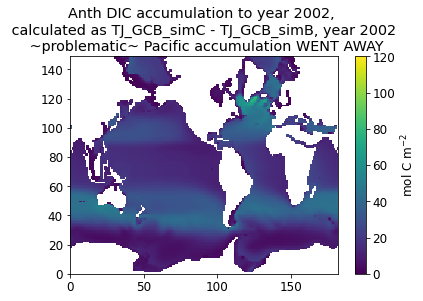

In [8]:
DIC_TJ_C_molm2 = GCB_TJ_C.DIC.load() * ds.e3t_0.load() * 1000 
DIC_TJ_B_molm2 = GCB_TJ_B.DIC.load() * ds.e3t_0.load() * 1000 
#multiplying by 1000 goes from mol/L > mol/m3, multiplying by ds.e3t_0 should give you  mol/m2

test = False
if test:
    #this checks that it did the thing and all the dimensions make sense
    print(GCB_TJ_C.DIC[0,0:4,50,100].values)
    print(ds.e3t_0[0,0:4,50,100].values)
    print(GCB_TJ_C.DIC[0,0:4,50,100].values * ds.e3t_0[0,0:4,50,100].values)
    print(DIC_TJ_C_molm2[0,0:4,50,100].values)
    
    
anth_DIC_molm2 = DIC_TJ_C_molm2-DIC_TJ_B_molm2
anth_DIC_molm2 = anth_DIC_molm2[:,0:27,:,:] #to 3000 m depth approximately, last cell has depth 3257
anth_DIC_molm2_2d = np.nanmean(np.nansum(anth_DIC_molm2, axis = 1), axis = 0) #yearly mean, summed across depths

anth_DIC_molm2_2d[anth_DIC_molm2_2d == 0] = np.nan
w = plt.pcolormesh(anth_DIC_molm2_2d, vmin = 0, vmax = 120)
plt.colorbar(w, label = 'mol C m$^{-2}$', )
plt.title('Anth DIC accumulation to year 2002, \n calculated as TJ_GCB_simC - TJ_GCB_simB, year 2002 \n ~problematic~ Pacific accumulation WENT AWAY')



Text(0.5, 1.0, 'GCB2023_ Anth DIC accumulation to year 2002, \n calculated as TJ_GCBn_simC - TJ_GCBn_simB, year 2002 \n ~problematic~ Pacific accumulation WENT AWAY')

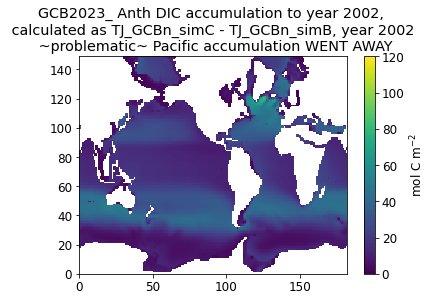

In [9]:
DIC_TJ_C_molm2 = GCBn_TJ_C.DIC.load() * ds.e3t_0.load() * 1000 
DIC_TJ_B_molm2 = GCBn_TJ_B.DIC.load() * ds.e3t_0.load() * 1000 
#multiplying by 1000 goes from mol/L > mol/m3, multiplying by ds.e3t_0 should give you  mol/m2

test = False
if test:
    #this checks that it did the thing and all the dimensions make sense
    print(GCBn_TJ_C.DIC[0,0:4,50,100].values)
    print(ds.e3t_0[0,0:4,50,100].values)
    print(GCBn_TJ_C.DIC[0,0:4,50,100].values * ds.e3t_0[0,0:4,50,100].values)
    print(DIC_TJ_C_molm2[0,0:4,50,100].values)
    
    
GCBn_anth_DIC_molm2 = DIC_TJ_C_molm2-DIC_TJ_B_molm2
GCBn_anth_DIC_molm2 = anth_DIC_molm2[:,0:27,:,:] #to 3000 m depth approximately, last cell has depth 3257
GCBn_anth_DIC_molm2_2d = np.nanmean(np.nansum(anth_DIC_molm2, axis = 1), axis = 0) #yearly mean, summed across depths

GCBn_anth_DIC_molm2_2d[GCBn_anth_DIC_molm2_2d == 0] = np.nan
w = plt.pcolormesh(GCBn_anth_DIC_molm2_2d, vmin = 0, vmax = 120)
plt.colorbar(w, label = 'mol C m$^{-2}$', )
plt.title('GCB2023_ Anth DIC accumulation to year 2002, \n calculated as TJ_GCBn_simC - TJ_GCBn_simB, year 2002 \n ~problematic~ Pacific accumulation WENT AWAY')



In [10]:
GCB2022_C = 'TOM12_DW_GC01'
GCB2022_B = 'TOM12_DW_GB01'

ERA2_SalRest_C = f'TOM12_TJ_DGC1'
ERA2_SalRest_B = f'TOM12_TJ_DGB1'


ERA_noSalRest_B = 'TOM12_PT_GW05'
ERA_noSalRest_C = 'TOM12_PT_GW04'

ERA_SalRest_B = 'TOM12_PT_GW07'
ERA_SalRest_C = 'TOM12_PT_GW06'

NCEP_noSalRest_B = 'TOM12_TJ_GRB2' #crashed
NCEP_noSalRest_C = 'TOM12_TJ_GRC1'

NCEP_SalRest_B = 'TOM12_TJ_GSB1'
NCEP_SalRest_C = 'TOM12_TJ_GSC1'

tdir = '/gpfs/home/mep22dku/scratch/SOZONE/GRO2_FORCING_EXPERIMENT/extracted/'

ds_GCB2022 = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_DW_GA01.nc') # change once dave's run is extracted
ds_NCEP_SalRest = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_RW_GS00.nc')
ds_NCEP_noSalRest = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_RW_GRO2.nc')
ds_ERA_noSalRest = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_RW_GERA.nc')
ds_ERA_SalRest = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_RW_GSER.nc')
ds_ERA2_SalRest = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_TJ_DGA1.nc')


In [11]:
def calcAnthC(B_run, C_run):
    
    #yr 2002 by GCB default
    yr = 2002
    #
    fpathC = f'/gpfs/afm/greenocean/software/runs/{C_run}/ORCA2_1m_{yr}0101_*_ptrc_T.nc'
    fpathB = f'/gpfs/afm/greenocean/software/runs/{B_run}/ORCA2_1m_{yr}0101_*_ptrc_T.nc'

    filC = xr.open_dataset(glob.glob(fpathC)[0])
    filB = xr.open_dataset(glob.glob(fpathB)[0])
    #print('found files')
    
    ### get size of cells to be able to calculate anth c accumulation
    #tj broadcast a depth array of e3t_0 to get its dimensions to match the model output we are trying to calculate for. 
    tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
    e3t_0 = tmesh.e3t_0
    e3t_0_rn = e3t_0.rename({'t': 'time_counter','z': 'deptht'})
    e3t_0_rn_b = np.zeros([12,31,149,182])

    for i in range(0,12):
        e3t_0_rn_b[i,:,:,:] = e3t_0_rn.values

    # savenam = 'test2.nc'
    data_vars = {'e3t_0':(['time_counter', 'deptht', 'y', 'x'], e3t_0_rn_b,
    {'units': 'm',
    'long_name':'meters, t grid'}),
    }
    # define coordinates
    coords = {'time_counter': (['time_counter'], GCB_DW_C.time_counter),
    'y': (['y'], tmesh.y.values),
    'x': (['x'], tmesh.x.values),
    'deptht': (['deptht'], GCB_DW_C.deptht.values)}
    # define global attributes
    attrs = {'made in':'SOZONE/GRO2_FORCING_EXPERIMENT/anthCarbonAccumulation_figx3.4.2.ipynb',
    'desc': 'a broadcasted e3t_0 into 12 months, for multiplication'
    }
    ds = xr.Dataset(data_vars=data_vars,
    coords=coords,
    attrs=attrs)
                
    DIC_filcC_molm2 = filC.DIC.load() * ds.e3t_0.load() * 1000 
    DIC_filcB_molm2 = filB.DIC.load() * ds.e3t_0.load() * 1000 
    #multiplying by 1000 goes from mol/L > mol/m3, multiplying by ds.e3t_0 should give you  mol/m2

    test = False
    if test:
        #this checks that it did the thing and all the dimensions make sense
        print(filC.DIC[0,0:4,50,100].values)
        print(ds.e3t_0[0,0:4,50,100].values)
        print(filC.DIC[0,0:4,50,100].values * ds.e3t_0[0,0:4,50,100].values)
        print(DIC_filcC_molm2[0,0:4,50,100].values)


    anth_DIC_molm2 = DIC_filcC_molm2-DIC_filcB_molm2
    anth_DIC_molm2 = anth_DIC_molm2[:,0:27,:,:] #to 3000 m depth approximately, last cell has depth 3257
    anth_DIC_molm2_2d = np.nanmean(np.nansum(anth_DIC_molm2, axis = 1), axis = 0) #yearly mean, summed across depths
    
    print(f'calculated anthDIC accumulation for {B_run}')



    return anth_DIC_molm2_2d

anth_DIC_GCB2022 = calcAnthC(GCB2022_B, GCB2022_C)
anth_DIC_ERA2_SalRest = calcAnthC(ERA2_SalRest_B, ERA2_SalRest_C)
anth_DIC_ERA_noSalRest = calcAnthC(ERA_noSalRest_B, ERA_noSalRest_C)
anth_DIC_ERA_SalRest = calcAnthC(ERA_SalRest_B, ERA_SalRest_C)
anth_DIC_NCEP_noSalRest = calcAnthC(NCEP_noSalRest_B, NCEP_noSalRest_C)
anth_DIC_NCEP_SalRest = calcAnthC(NCEP_SalRest_B, NCEP_SalRest_C)

#anth_DIC_NCEP_noSalRest = np.zeros_like(anth_DIC_NCEP_SalRest) #placeholder for plotting

calculated anthDIC accumulation for TOM12_DW_GB01
calculated anthDIC accumulation for TOM12_TJ_DGB1
calculated anthDIC accumulation for TOM12_PT_GW05
calculated anthDIC accumulation for TOM12_PT_GW07
calculated anthDIC accumulation for TOM12_TJ_GRB2
calculated anthDIC accumulation for TOM12_TJ_GSB1


### 2) Calculate C-anth accumulation, roughly, 1955-1960 -2000-2005, for an array of new models

different methodology, we only have simulation "A" for these, dynamic climate and rising CO2

so I will calculate mean C molm2 for years [1955-1960] and years [2000-2005] and subtract them. This calculation isn't the same as the one above but it will give me  an idea of the spatial distribution. 



extract relevant metrics in /gpfs/home/mep22dku/scratch/SOZONE/GRO2_FORCING_EXPERIMENT/runner.py

Text(0.5, 0.96, 'Anth. DIC accumulation to year 2002, calculated as C run - B run, top 3000m  \n 2 forcing types (NCEP/ERA), salinity restoration on/off')

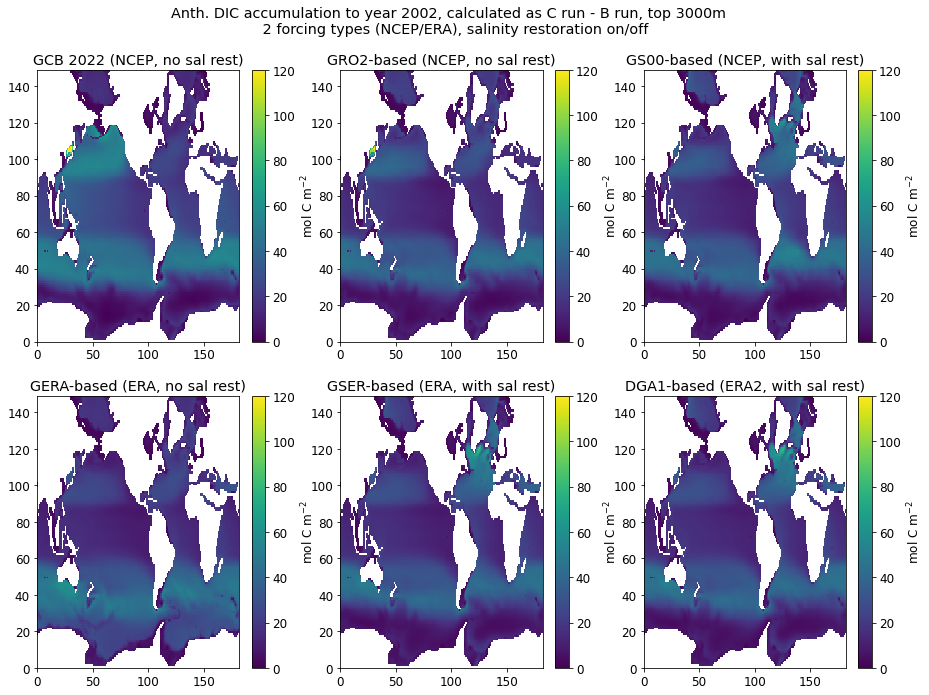

In [12]:
fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(14*fact, 10*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

anthdics = [anth_DIC_GCB2022, anth_DIC_NCEP_noSalRest, anth_DIC_NCEP_SalRest,\
           anth_DIC_ERA_noSalRest, anth_DIC_ERA_SalRest, anth_DIC_ERA2_SalRest]


titles = ['GCB 2022 (NCEP, no sal rest)',
          'GRO2-based (NCEP, no sal rest)',
          'GS00-based (NCEP, with sal rest)',
          'GERA-based (ERA, no sal rest)',
          'GSER-based (ERA, with sal rest)',
          'DGA1-based (ERA2, with sal rest)',
         ]
          
#           GS00 (NCEP with salinity restoring)',
#           'GRO2 (NCEP without salinity restoring)',
#           'GSER (ERA with salinity restoring)',
#           'GERA (ERA without salinity restoring)',
#           'TJ_1ASA (old milestone + UKESMforcing)',
#           'TJ_DGA1 (new milestone + ERA2, with sal. rest)']

for i in range(0,len(anthdics)):
    tanth = anthdics[i]
    tanth[tanth == 0] = np.nan
    w = axs[i].pcolormesh(tanth, vmin = 0, vmax = 120)
    plt.colorbar(w, label = 'mol C m$^{-2}$', ax = axs[i] )
    axs[i].set_title(titles[i])

    
tit = 'Anth. DIC accumulation to year 2002, calculated as C run - B run, top 3000m  \n 2 forcing types (NCEP/ERA), salinity restoration on/off'
    
plt.suptitle(tit, y = 0.96)



[ 10.  10.  10.  20.  25.  25.  25.  25.  50.  50.  50. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 250. 250. 500. 500. 500.
   0.   0.   0.   0.   0.]


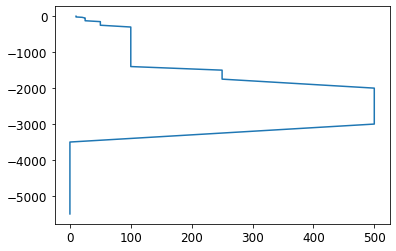

In [13]:
glodap = '/gpfs/data/greenocean/observations/GLODAPv2.2016b_MappedClimatologies/'

Tf = xr.open_dataset(f'{glodap}GLODAPv2.2016b.temperature.nc')
depths = Tf.Depth.values

#to 3000 meters

depths[27]

csizes = np.zeros_like(depths)
for i in range(0,32):
    
    csizes[i] = depths[i+1] - depths[i]
    
csizes[28:33] = 0

print(csizes)
plt.plot(csizes,-depths)

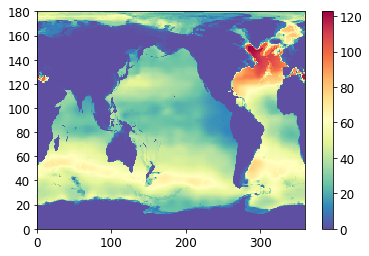

In [14]:
import gsw 

glocarb = xr.open_dataset('/gpfs/data/greenocean/observations/GLODAPv2.2016b_MappedClimatologies/GLODAPv2.2016b.Cant.nc')
glodap = '/gpfs/data/greenocean/observations/GLODAPv2.2016b_MappedClimatologies/'

Tf = xr.open_dataset(f'{glodap}GLODAPv2.2016b.temperature.nc')
Sf = xr.open_dataset(f'{glodap}GLODAPv2.2016b.salinity.nc')
DICf = xr.open_dataset(f'{glodap}GLODAPv2.2016b.TCO2.nc')

T = Tf['temperature'].values #in situ
S = Sf['salinity'].values * 35.16504/35.000 #reference salt

pressure = np.zeros([33,180,360])
csizes_glodap = np.zeros([33,180,360])
for i in range(0,180):
    for j in range(0,360):
        pressure[:,i,j] = Tf.Depth.values
        csizes_glodap[:,i,j] = csizes

dens = gsw.density.rho_t_exact(S, T, pressure)
Cant = glocarb.Cant.values
DIC = DICf.TCO2.values
Cant_mu=Cant*dens/1000 * 1e-3  #umol/L > need mol/m3 
DIC_mu = DIC*dens/1000

Cant_mu_m2 = Cant_mu * csizes_glodap #*m to mol/m2

w = plt.pcolormesh(np.nansum(Cant_mu_m2, axis = 0), cmap = 'Spectral_r') #this is the answer
plt.colorbar(w)


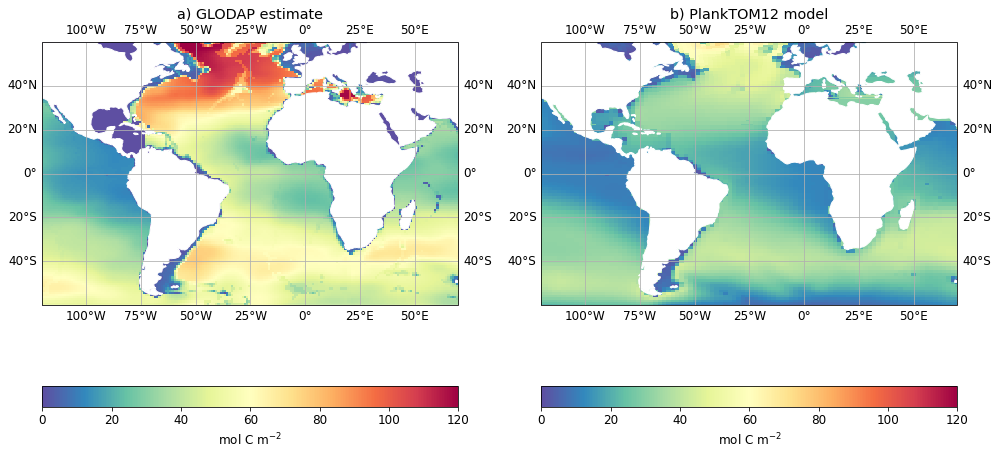

In [15]:
tfil = xr.open_dataset('/gpfs/data/greenocean/software/runs/TOM12_DW_GA01/ORCA2_1m_19810101_19811231_ptrc_T.nc')
tdat = tfil.DIC[0,0,:,:].values
lats = tfil.nav_lat; lons = tfil.nav_lon

lonleft = -120; lonright = 70
latbot = -60; lattop = 60

fact = 0.8
fig = plt.figure(figsize=[20.5*fact, 12.5*fact])

ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
                    
ax.coastlines()
#lons, lats extent
ax.set_extent([lonleft, lonright, latbot, lattop], crs=ccrs.PlateCarree())

mesh = ax.pcolormesh(Tf.lon.values, Tf.lat.values, np.nansum(Cant_mu_m2, axis = 0), vmin = 0, vmax = 120, cmap = 'Spectral_r',
                 transform=ccrs.PlateCarree())
plt.colorbar(mesh, orientation = 'horizontal', label = 'mol C m$^{-2}$')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                             edgecolor='face', facecolor='w'))
ax.set_title('a) GLODAP estimate')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

### model
ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([lonleft, lonright, latbot, lattop], crs=ccrs.PlateCarree())

mesh = ax.pcolormesh(lons, lats, anth_DIC_ERA_SalRest, vmin = 0, vmax = 120, cmap = 'Spectral_r',
                 transform=ccrs.PlateCarree())
plt.colorbar(mesh, orientation = 'horizontal', label = 'mol C m$^{-2}$')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                             edgecolor='face', facecolor='w'))

ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.set_title('b) PlankTOM12 model')
plt.show()



In [16]:
dic_res = xr.open_dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_DGA1/ORCA2_1m_20020101_20021231_ptrc_T.nc')


In [17]:
surf_dic = np.nanmean(dic_res.DIC[:,0,:,:], axis = 0) * 1e6

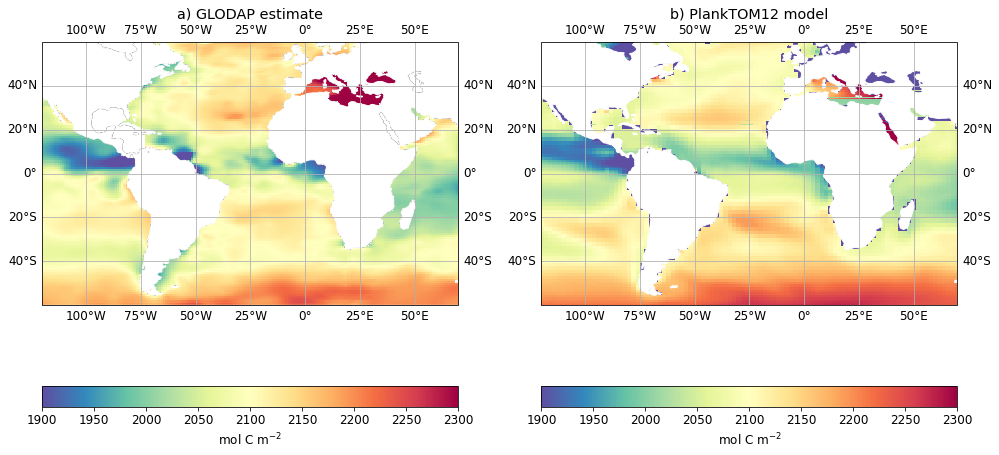

In [18]:
lonleft = -120; lonright = 70
latbot = -60; lattop = 60
tvmin = 1900; tvmax = 2300
fact = 0.8
fig = plt.figure(figsize=[20.5*fact, 12.5*fact])

ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
                    
ax.coastlines()
#lons, lats extent
ax.set_extent([lonleft, lonright, latbot, lattop], crs=ccrs.PlateCarree())

mesh = ax.pcolormesh(Tf.lon.values, Tf.lat.values, DIC_mu[0,:,:], vmin = tvmin, vmax = tvmax, cmap = 'Spectral_r',
                 transform=ccrs.PlateCarree())
plt.colorbar(mesh, orientation = 'horizontal', label = 'mol C m$^{-2}$')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                             edgecolor='face', facecolor='w'))
ax.set_title('a) GLODAP estimate')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

### model
ax = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([lonleft, lonright, latbot, lattop], crs=ccrs.PlateCarree())

mesh = ax.pcolormesh(lons, lats, surf_dic, vmin = tvmin, vmax = tvmax, cmap = 'Spectral_r',
                 transform=ccrs.PlateCarree())
plt.colorbar(mesh, orientation = 'horizontal', label = 'mol C m$^{-2}$')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                             edgecolor='face', facecolor='w'))

ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.set_title('b) PlankTOM12 model')
plt.show()



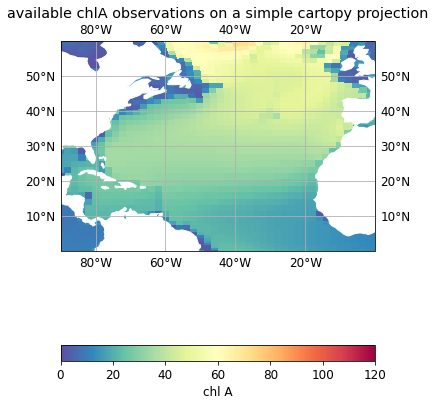

In [19]:

fact = 0.8
tfig = plt.figure(figsize=[10.5*fact, 14.5*fact])


                      
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#lons, lats extent
ax.set_extent([-90, 0, 0, 60], crs=ccrs.PlateCarree())
tvmin = 1.8e-3; tvmax = 2.301e-3; intvl = 1e-4

#anth_DIC_ERA_SalRest, vmin = 0, vmax = 120, cmap = 'Spectral_r')

mesh = plt.pcolormesh(lons, lats, anth_DIC_ERA_SalRest, vmin = 0, vmax = 120, cmap = 'Spectral_r',
                 transform=ccrs.PlateCarree())
plt.colorbar(mesh, orientation = 'horizontal', label = 'chl A')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                             edgecolor='face', facecolor='w'))

ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

plt.title('available chlA observations on a simple cartopy projection')
plt.tight_layout()
plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


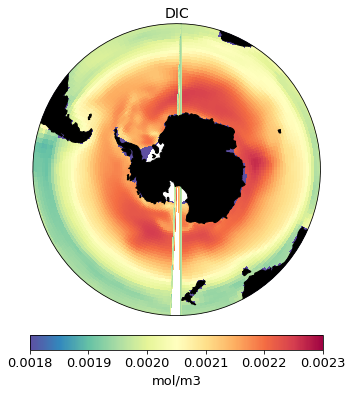

In [20]:
def plot_southern(fig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, tticks, fs = 12, 
                  tit = '', cbarlab = '', tcmap = 'viridis', lm = True, cbr = True):
   
    ax1.set_extent([-180, 180, -80, -28], ccrs.PlateCarree())
    #make that circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax1.set_boundary(circle, transform=ax1.transAxes)
    mesh = ax1.pcolormesh(lons, lats, tdat, cmap = tcmap, vmin = tvmin, vmax = tvmax, 
                     transform=ccrs.PlateCarree())
    
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', 
                                                 edgecolor='face', facecolor='k'))

    ax1.set_title(tit, fontsize = fs)
    cb = 0
    if cbr:
        cb = fig.colorbar(mesh, ax = ax1, orientation = 'horizontal',
                     pad = 0.06, fraction = 0.045, shrink = 0.9)
        cb.set_label(label=cbarlab,fontsize = fs-1)
        cb.set_ticks(tticks, fontsize = 80)
        cb.ax.tick_params(labelsize=fs-1)
    return cb


#### open file
tfil = xr.open_dataset('/gpfs/data/greenocean/software/runs/TOM12_DW_GA01/ORCA2_1m_19810101_19811231_ptrc_T.nc')
tdat = tfil.DIC[0,0,:,:].values
lats = tfil.nav_lat; lons = tfil.nav_lon
tvmin = 1.8e-3; tvmax = 2.301e-3; intvl = 1e-4
tticks = np.arange(tvmin , tvmax, intvl)
tcbarlab = 'mol/m3'; ttit = 'DIC'
tfs = 14

fact = 0.6
fig = plt.figure(figsize=[10*fact, 10*fact])
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, -90))

plot_southern(fig, ax1, lons, lats, tdat, tvmin, 
                  tvmax, tticks, fs = tfs, 
                  tit = ttit, cbarlab = tcbarlab, tcmap = 'Spectral_r', lm = True, cbr = True)


In [21]:
tfil

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 31, time_counter: 12, x: 182, y: 149)
Coordinates:
    nav_lat               (y, x) float32 -78.19058 -78.19058 ... 49.978893
    nav_lon               (y, x) float32 78.00004 80.0 ... 80.22104 80.0
  * deptht                (deptht) float32 4.999938 15.000288 ... 5250.2266
    time_centered         (time_counter) object ...
  * time_counter          (time_counter) object 1981-01-16 12:00:00 ... 1981-...
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    Alkalini              (time_counter, deptht, y, x) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) object ...
    time_counter_bounds   (time_counter, axis_nbounds) object ...
    O2                    (time_counter, deptht, y, x) float32 ...
    DIC                   (time_counter, deptht, y, x) float32 ...
    PIIC                  (time_counter, deptht, y, x) float32 ...
    NO3                   (time_counter, deptht, y, x) float32 ...
    Si                    (time_counter, deptht, y, x) float32 ...
    PO4                   (time_counter, deptht, y, x) float32 ...
    Fer                   (time_counter, deptht, y, x) float32 ...
    DOC                   (time_counter, deptht, y, x) float32 ...
    CaCO3                 (time_counter, deptht, y, x) float32 ...
    ARA                   (time_counter, deptht, y, x) float32 ...
    POC                   (time_counter, deptht, y, x) float32 ...
    GOC                   (time_counter, deptht, y, x) float32 ...
    BAC                   (time_counter, deptht, y, x) float32 ...
    PRO                   (time_counter, deptht, y, x) float32 ...
    PTE                   (time_counter, deptht, y, x) float32 ...
    MES                   (time_counter, deptht, y, x) float32 ...
    GEL                   (time_counter, deptht, y, x) float32 ...
    MAC                   (time_counter, deptht, y, x) float32 ...
    DIA                   (time_counter, deptht, y, x) float32 ...
    MIX                   (time_counter, deptht, y, x) float32 ...
    COC                   (time_counter, deptht, y, x) float32 ...
    PIC                   (time_counter, deptht, y, x) float32 ...
    PHA                   (time_counter, deptht, y, x) float32 ...
    FIX                   (time_counter, deptht, y, x) float32 ...
    C11                   (time_counter, deptht, y, x) float32 ...
    B14B                  (time_counter, deptht, y, x) float32 ...
    C14B                  (time_counter, deptht, y, x) float32 ...
    D14B                  (time_counter, deptht, y, x) float32 ...
Attributes:
    name:         ORCA2_1m_19810101_19811231
    description:  planktom sms variables
    title:        planktom sms variables
    Conventions:  CF-1.5
    production:   An IPSL model
    timeStamp:    2022-Jun-07 12:59:30 BST

In [22]:
tfil

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 31, time_counter: 12, x: 182, y: 149)
Coordinates:
    nav_lat               (y, x) float32 -78.19058 -78.19058 ... 49.978893
    nav_lon               (y, x) float32 78.00004 80.0 ... 80.22104 80.0
  * deptht                (deptht) float32 4.999938 15.000288 ... 5250.2266
    time_centered         (time_counter) object 1981-01-16 12:00:00 ... 1981-...
  * time_counter          (time_counter) object 1981-01-16 12:00:00 ... 1981-...
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    deptht_bounds         (deptht, axis_nbounds) float32 0.0 ... 5500.5645
    Alkalini              (time_counter, deptht, y, x) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) object 1981-01-01 00:0...
    time_counter_bounds   (time_counter, axis_nbounds) object 1981-01-01 00:0...
    O2                    (time_counter, deptht, y, x) float32 ...
    DIC                   (time_counter, deptht, y, x) float32 ...
    PIIC                  (time_counter, deptht, y, x) float32 ...
    NO3                   (time_counter, deptht, y, x) float32 ...
    Si                    (time_counter, deptht, y, x) float32 ...
    PO4                   (time_counter, deptht, y, x) float32 ...
    Fer                   (time_counter, deptht, y, x) float32 ...
    DOC                   (time_counter, deptht, y, x) float32 ...
    CaCO3                 (time_counter, deptht, y, x) float32 ...
    ARA                   (time_counter, deptht, y, x) float32 ...
    POC                   (time_counter, deptht, y, x) float32 ...
    GOC                   (time_counter, deptht, y, x) float32 ...
    BAC                   (time_counter, deptht, y, x) float32 ...
    PRO                   (time_counter, deptht, y, x) float32 ...
    PTE                   (time_counter, deptht, y, x) float32 ...
    MES                   (time_counter, deptht, y, x) float32 ...
    GEL                   (time_counter, deptht, y, x) float32 ...
    MAC                   (time_counter, deptht, y, x) float32 ...
    DIA                   (time_counter, deptht, y, x) float32 ...
    MIX                   (time_counter, deptht, y, x) float32 ...
    COC                   (time_counter, deptht, y, x) float32 ...
    PIC                   (time_counter, deptht, y, x) float32 ...
    PHA                   (time_counter, deptht, y, x) float32 ...
    FIX                   (time_counter, deptht, y, x) float32 ...
    C11                   (time_counter, deptht, y, x) float32 ...
    B14B                  (time_counter, deptht, y, x) float32 ...
    C14B                  (time_counter, deptht, y, x) float32 ...
    D14B                  (time_counter, deptht, y, x) float32 ...
Attributes:
    name:         ORCA2_1m_19810101_19811231
    description:  planktom sms variables
    title:        planktom sms variables
    Conventions:  CF-1.5
    production:   An IPSL model
    timeStamp:    2022-Jun-07 12:59:30 BST

In [23]:
np.nanmax(tdat)

0.0025749218